**Most Frequently Seen Bird**

Total number of birds per date:
Date Created
2013-06-15    1054
2013-06-16    2637
2013-06-17    1361
2013-06-18     885
2013-06-19     231
              ... 
2021-06-19      31
2021-06-20      69
2021-06-21      21
2021-07-01      19
2021-07-12      27
Name: Number of Birds, Length: 190, dtype: int64

Total number of birds in the entire dataset: 57036


<Figure size 1400x800 with 0 Axes>

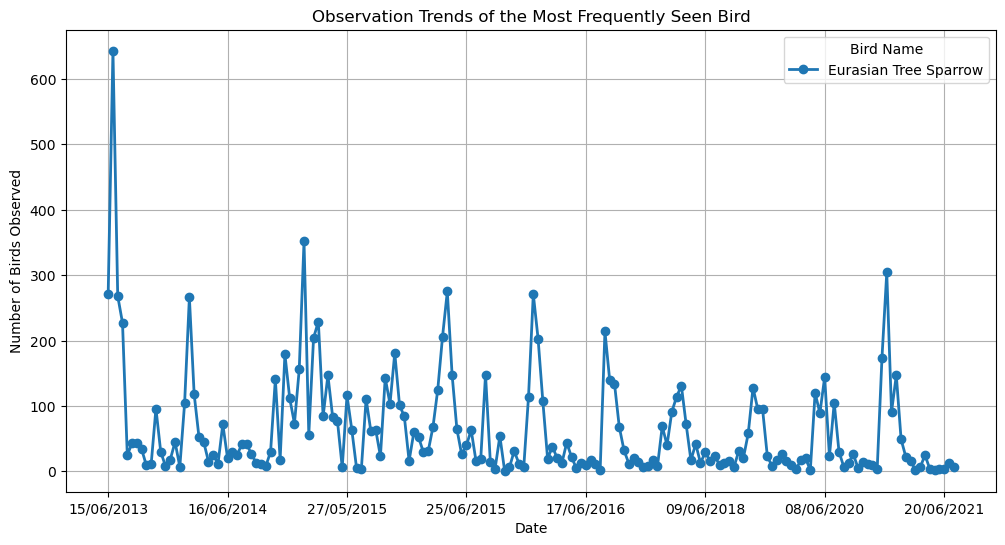

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time

file_path = "birds_observation_data_with_index.csv"
df = pd.read_csv(file_path)

df.columns = df.columns.str.strip()

df['Date Created'] = pd.to_datetime(df['Date Created'], format='%d/%m/%Y')

top_birds = df.groupby("Bird Name")["Number of Birds"].sum().nlargest(1).index

top_birds_df = df[df["Bird Name"].isin(top_birds)]

bird_trends = top_birds_df.groupby(["Date Created", "Bird Name"])["Number of Birds"].sum().unstack()

bird_trends.index = bird_trends.index.strftime('%d/%m/%Y')

df_daily = df.groupby("Date Created")["Number of Birds"].sum()  
print("Total number of birds per date:")
print(df_daily)

total_birds = df['Number of Birds'].sum()
print(f"\nTotal number of birds in the entire dataset: {total_birds}")

plt.figure(figsize=(14, 8))
bird_trends.plot(kind="line", marker="o", linewidth=2, figsize=(12, 6), colormap="tab10")
plt.xlabel("Date")
plt.ylabel("Number of Birds Observed")
plt.title("Observation Trends of the Most Frequently Seen Bird")
plt.legend(title="Bird Name")
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time


file_path = "birds_observation_data_with_index.csv"
df = pd.read_csv(file_path)

# Most frequent bird
bird_counts = df['Bird Name'].value_counts()
most_frequent_bird = bird_counts.index[0]
bird_data = df[df['Bird Name'] == most_frequent_bird]
bird_trend = bird_data.groupby('Date Index')['Number of Birds'].sum()
values = bird_trend.values.astype('float32').reshape(-1, 1)
print("Most frequently seen bird:", most_frequent_bird)

print(values.mean())

# Normalization
values_log = np.log1p(values)  
values_scaled = values_log

Second most frequently seen bird: Eurasian Tree Sparrow


In [ ]:
# window_size = 5
# window_size = 10
window_size = 20
# window_size = 25
# window_size = 30
# window_size = 50

# Sliding Window For Multistep Forecast
def create_multistep_dataset(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size]) 
        Y.append(data[i + window_size]) 
    return np.array(X), np.array(Y)

X, Y = create_multistep_dataset(values_scaled, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape to (samples, time steps, features)

c:\Users\tsimi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training time: 176.00 seconds


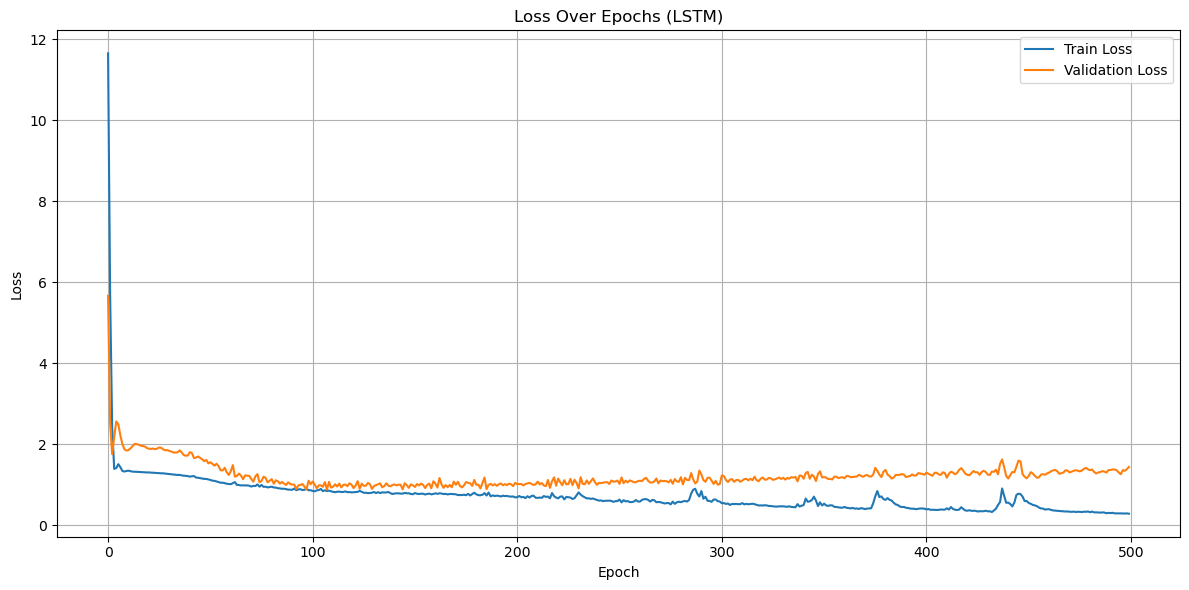

In [ ]:
# Train/Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]


start = time.time()

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))


history = model.fit(X_train, 
                    Y_train, 
                    epochs=500, 
                    verbose=0, 
                    validation_data=(X_test, Y_test)
                    )

print(f"Training time: {time.time() - start:.2f} seconds")


# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (LSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Save Model**

In [ ]:
# model.save('lstm_bird_model.h5')
# print("Model saved as lstm_bird_model.h5")

**Load Saved Model**

In [ ]:
from tensorflow.keras.models import load_model

# model = load_model('lstm_bird_model.h5')

# **Forecasting for Future Trend**

## **window size of 5**

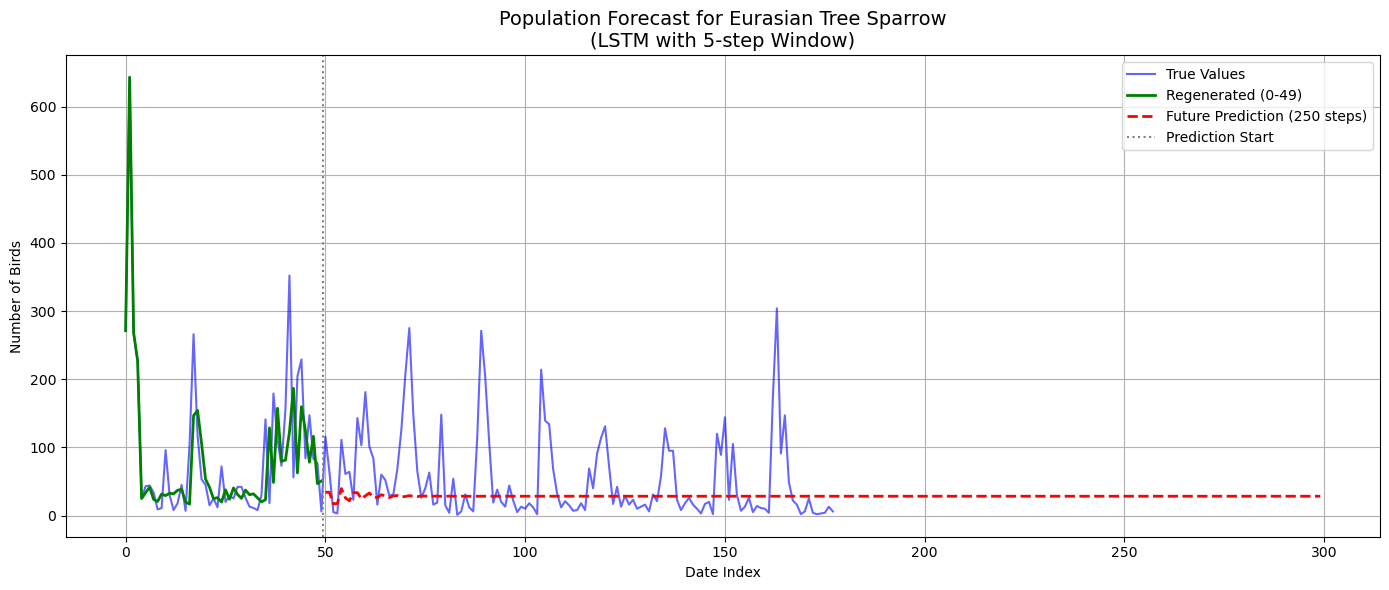

Model Performance Metrics of LSTM with 5-step Window:
MSE: 4314.1880
RMSE: 65.6825
MAE: 44.4801


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []

#------------------------
# start from index 0 because before index 0, there is no historical data. So, the first window size is displayed based on the actual data.
# -----------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])

# ----------------------------------------------
# predictions for points from window_size onwards
# ----------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# ---------------------------
# Future predictions 
# ----------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# --------------------
# Ploting
# --------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]

# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

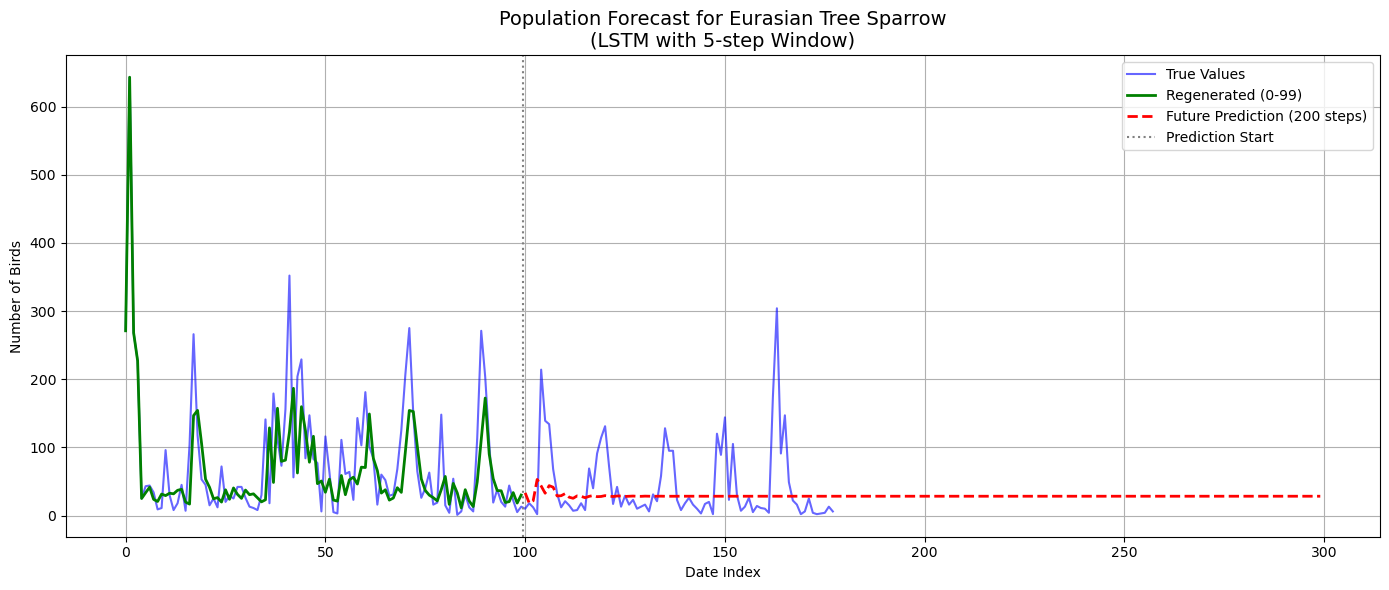

Model Performance Metrics of LSTM with 5-step Window:
MSE: 3406.6177
RMSE: 58.3662
MAE: 39.4381


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []

# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

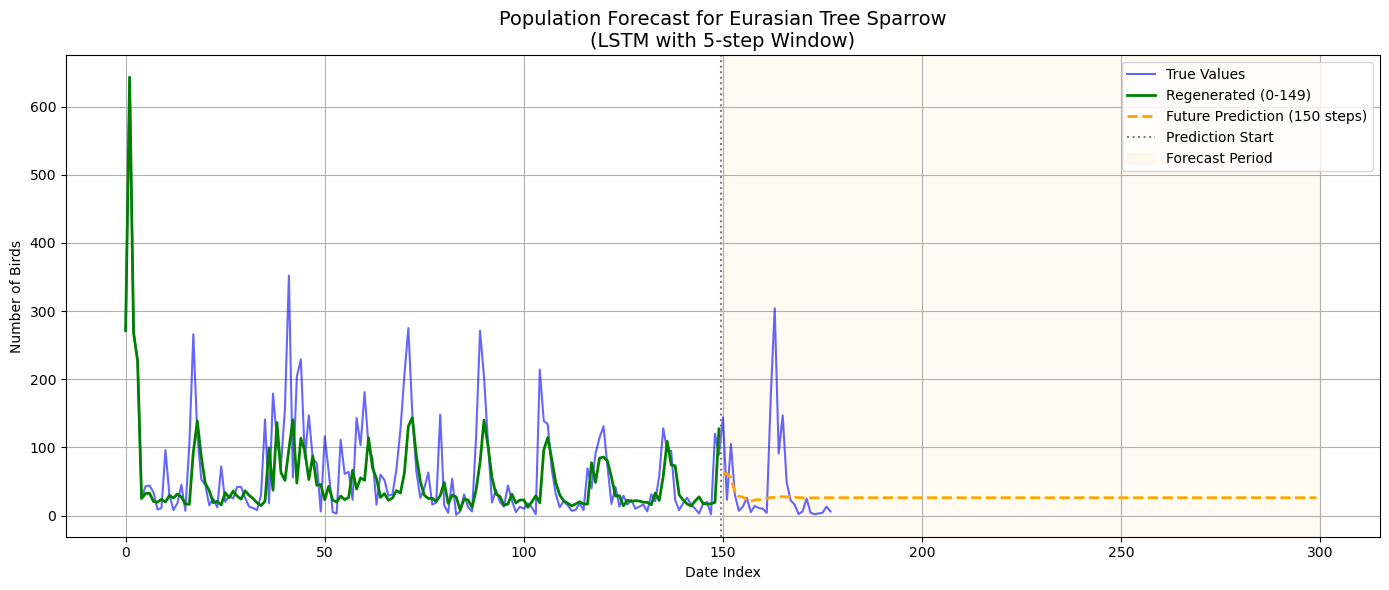

Model Performance Metrics of LSTM with 5-step Window:
MSE: 3295.7590
RMSE: 57.4087
MAE: 35.6454
MAPE: 118.16%


In [29]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')
plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 


print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


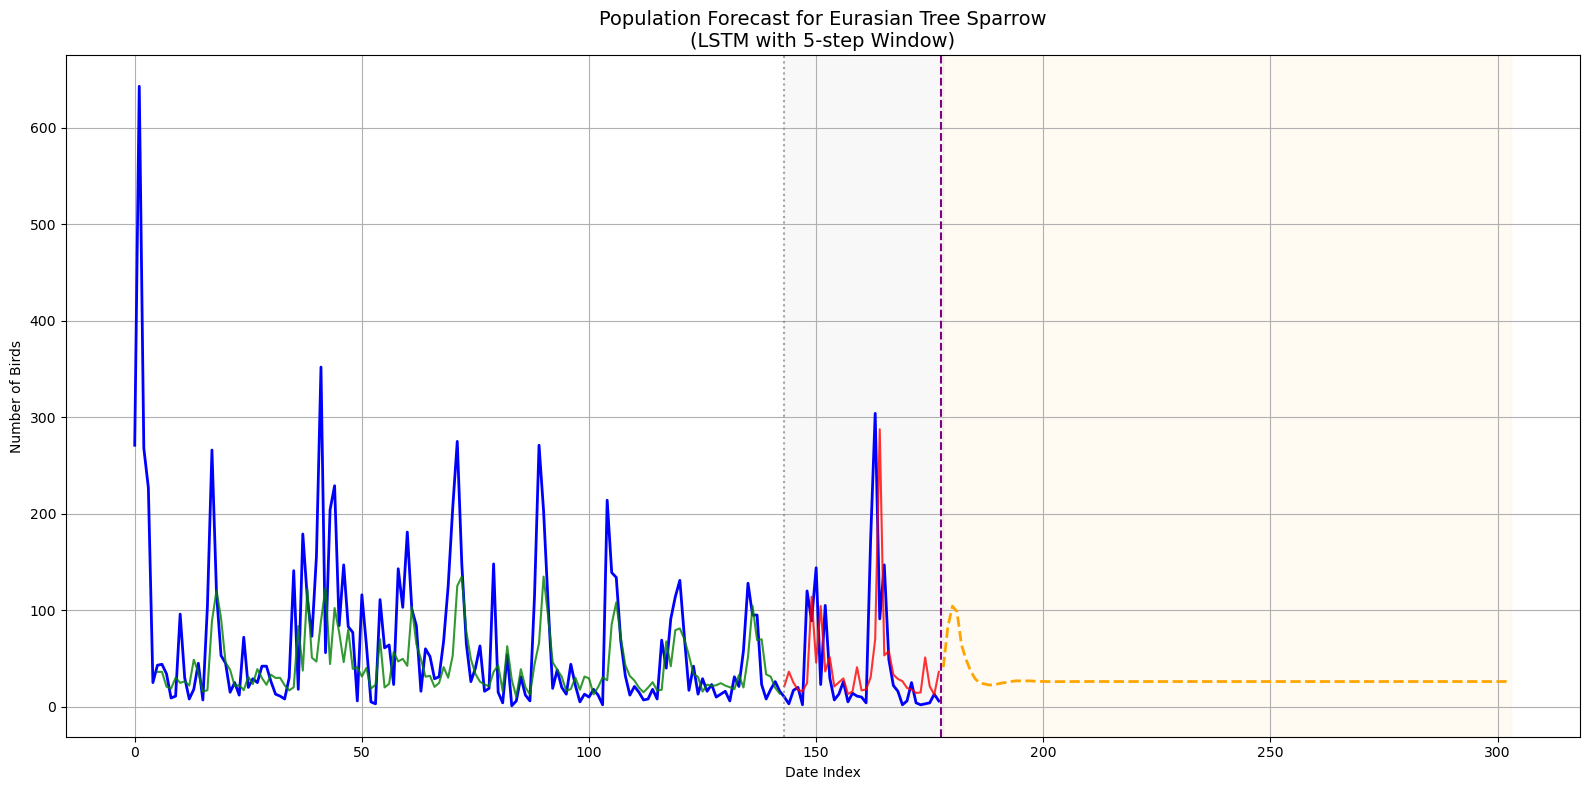


Model Performance Metrics of LSTM with 5-step Window:


Traning:

Training RMSE: 58.46
Training MSE: 3417.30
Training MAE: 35.67
Training MAPE: 111.80%

Testing:

Test RMSE: 68.05
Test MSE: 4630.68
Test MAE: 40.40
Test MAPE: 266.06%


In [7]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:\n")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [6]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 41.11
Step 2: 83.06
Step 3: 104.17
Step 4: 98.54
Step 5: 64.09
Step 6: 48.86
Step 7: 37.21
Step 8: 28.93
Step 9: 24.67
Step 10: 23.65
Step 11: 22.59
Step 12: 22.48
Step 13: 23.65
Step 14: 24.68
Step 15: 25.18
Step 16: 26.14
Step 17: 26.83
Step 18: 26.75
Step 19: 26.73
Step 20: 26.81
Step 21: 26.49
Step 22: 26.19
Step 23: 26.17
Step 24: 26.07
Step 25: 25.91
Step 26: 25.96
Step 27: 26.03
Step 28: 25.99
Step 29: 26.03
Step 30: 26.11
Step 31: 26.10
Step 32: 26.09
Step 33: 26.13
Step 34: 26.13
Step 35: 26.10
Step 36: 26.11
Step 37: 26.11
Step 38: 26.09
Step 39: 26.09
Step 40: 26.10
Step 41: 26.09
Step 42: 26.09
Step 43: 26.10
Step 44: 26.10
Step 45: 26.09
Step 46: 26.10
Step 47: 26.10
Step 48: 26.09
Step 49: 26.10
Step 50: 26.10
Step 51: 26.10
Step 52: 26.09
Step 53: 26.10
Step 54: 26.10
Step 55: 26.09
Step 56: 26.10
Step 57: 26.10
Step 58: 26.10
Step 59: 26.10
Step 60: 26.10
Step 61: 26.10
Step 62: 26.10
Step 63: 26.10
Step 64: 26.10
Step 65: 26.10
S

## **window size of 10**

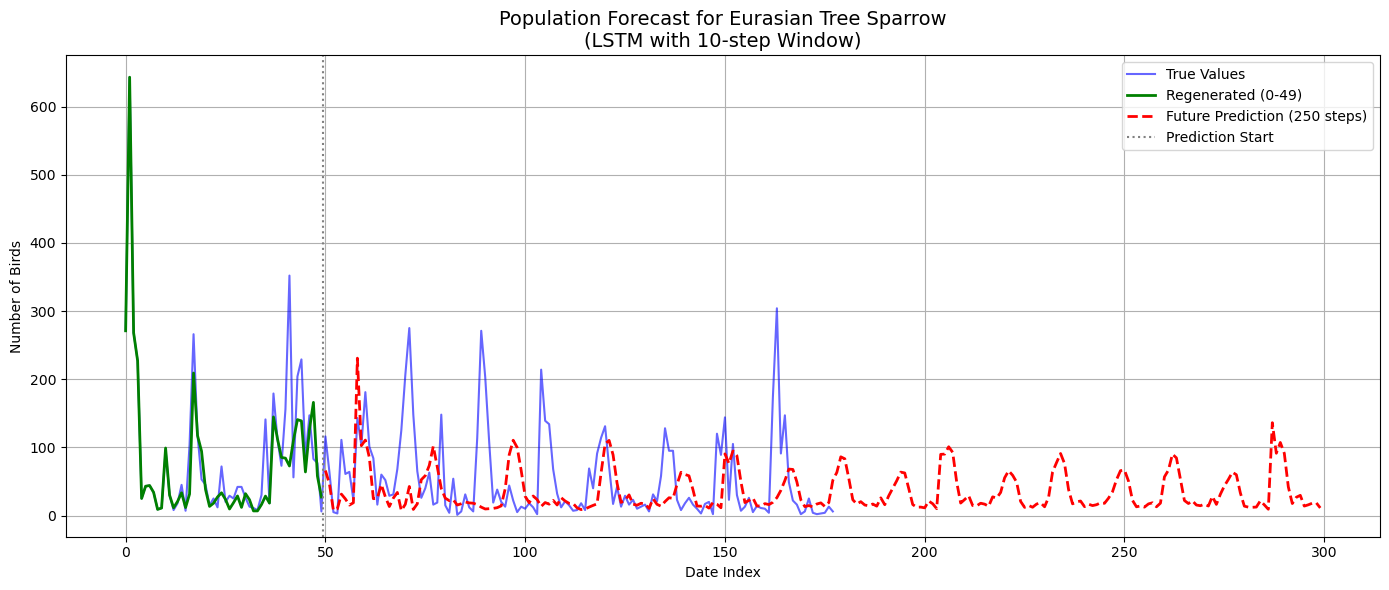

Model Performance Metrics of LSTM with 10-step Window:
MSE: 3372.8542
RMSE: 58.0763
MAE: 31.4550


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

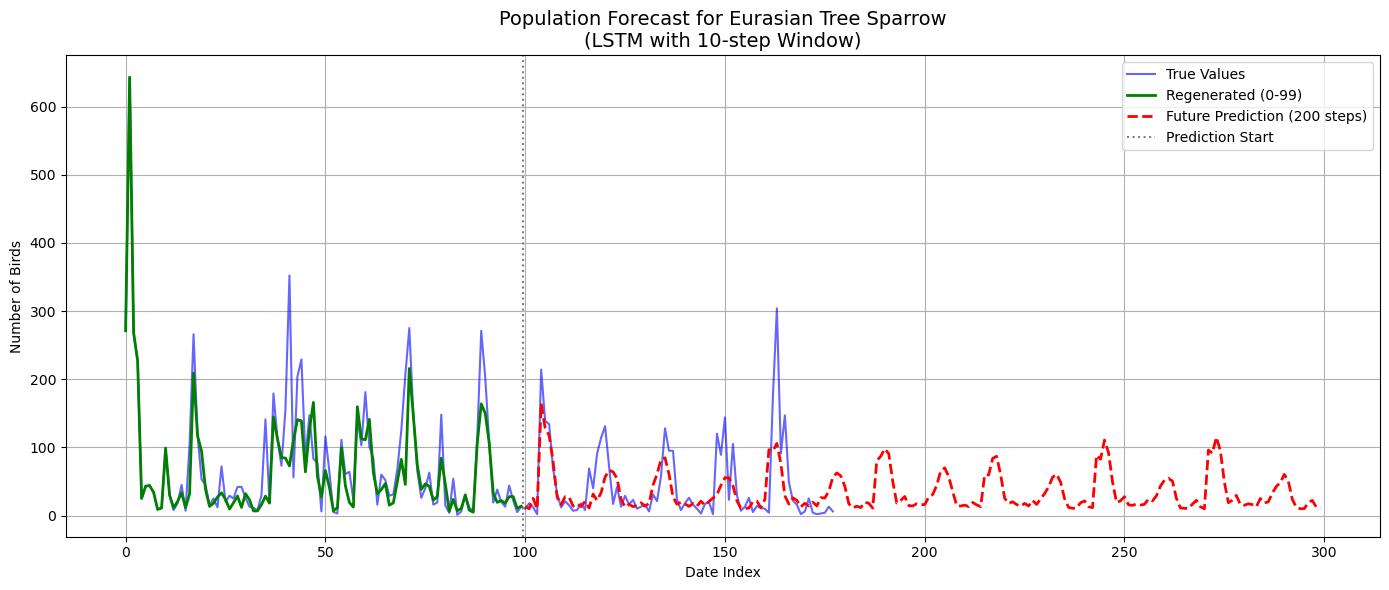

Model Performance Metrics of LSTM with 10-step Window:
MSE: 2250.4805
RMSE: 47.4392
MAE: 26.4359


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

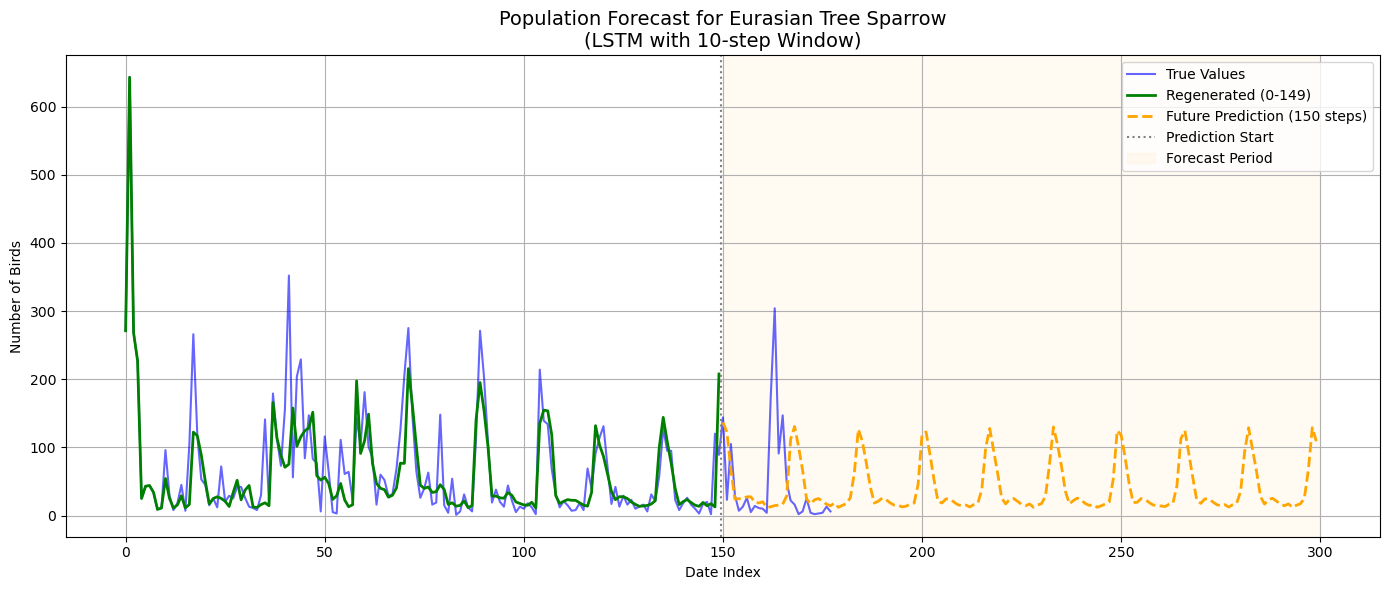

Model Performance Metrics of LSTM with 10-step Window:
MSE: 2141.1765
RMSE: 46.2729
MAE: 27.3537
MAPE: 85.22%


In [33]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')
plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 


print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


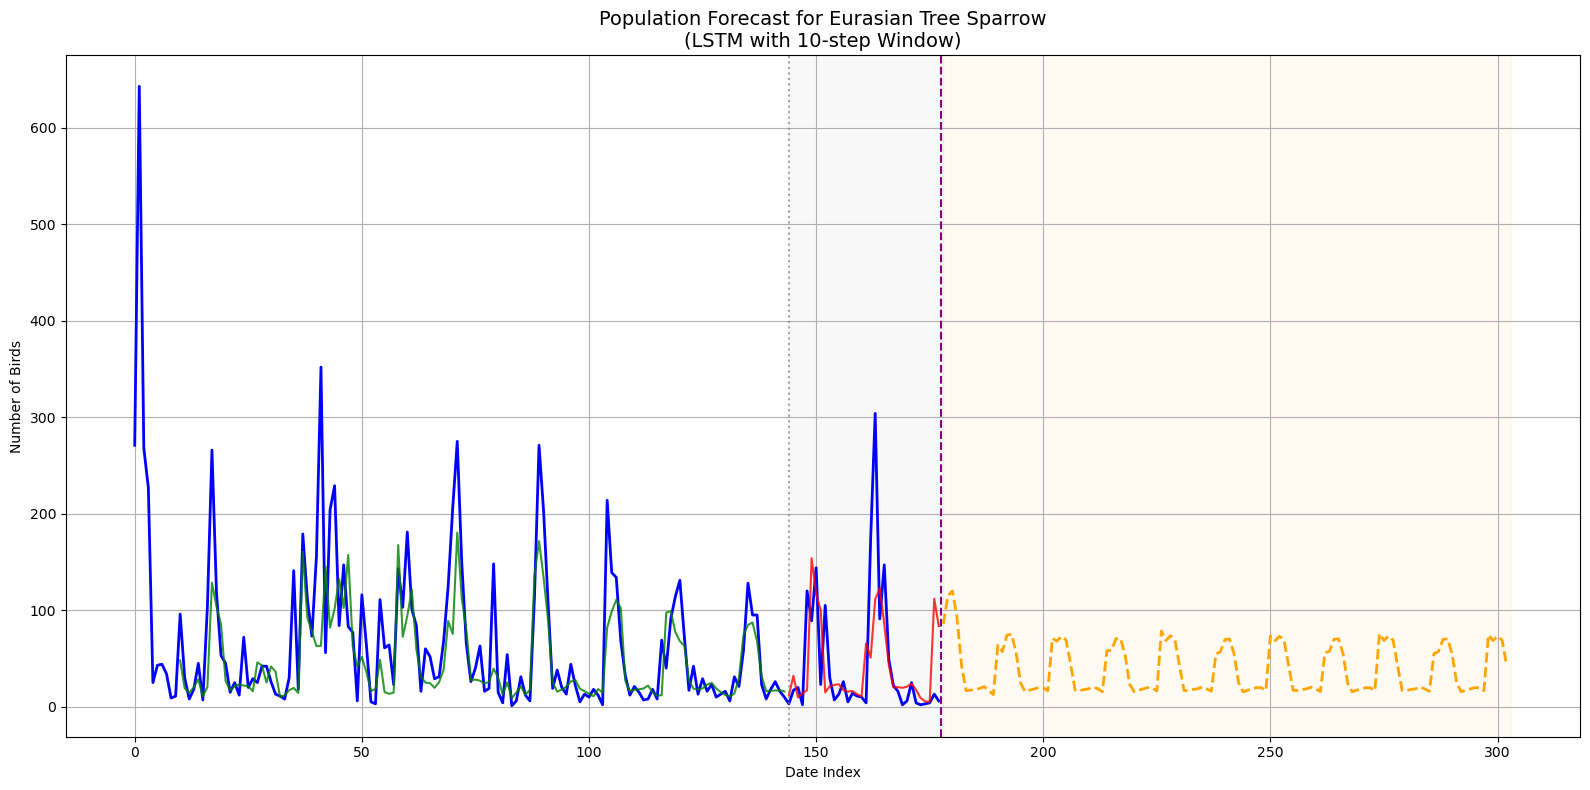


Model Performance Metrics of LSTM with 10-step Window:

Traning:

Training RMSE: 48.74
Training MSE: 2375.51
Training MAE: 28.98
Training MAPE: 69.39%

Testing:

Test RMSE: 56.42
Test MSE: 3183.12
Test MAE: 34.79
Test MAPE: 235.86%


In [11]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [12]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 85.86
Step 2: 114.99
Step 3: 119.98
Step 4: 92.90
Step 5: 43.14
Step 6: 16.63
Step 7: 17.26
Step 8: 17.31
Step 9: 19.02
Step 10: 20.72
Step 11: 16.86
Step 12: 12.53
Step 13: 63.74
Step 14: 57.00
Step 15: 74.18
Step 16: 75.19
Step 17: 56.76
Step 18: 24.33
Step 19: 15.69
Step 20: 17.13
Step 21: 18.40
Step 22: 19.83
Step 23: 19.49
Step 24: 16.49
Step 25: 70.90
Step 26: 67.97
Step 27: 72.90
Step 28: 69.37
Step 29: 44.76
Step 30: 17.38
Step 31: 16.69
Step 32: 17.82
Step 33: 18.56
Step 34: 20.32
Step 35: 18.68
Step 36: 15.39
Step 37: 58.00
Step 38: 58.46
Step 39: 70.45
Step 40: 70.62
Step 41: 53.89
Step 42: 23.44
Step 43: 15.54
Step 44: 17.20
Step 45: 18.46
Step 46: 19.87
Step 47: 19.53
Step 48: 16.30
Step 49: 78.36
Step 50: 68.54
Step 51: 73.68
Step 52: 69.13
Step 53: 41.92
Step 54: 16.67
Step 55: 17.01
Step 56: 17.96
Step 57: 18.61
Step 58: 20.36
Step 59: 18.41
Step 60: 16.02
Step 61: 54.52
Step 62: 57.05
Step 63: 69.62
Step 64: 70.18
Step 65: 54.73


## **window size of 20**

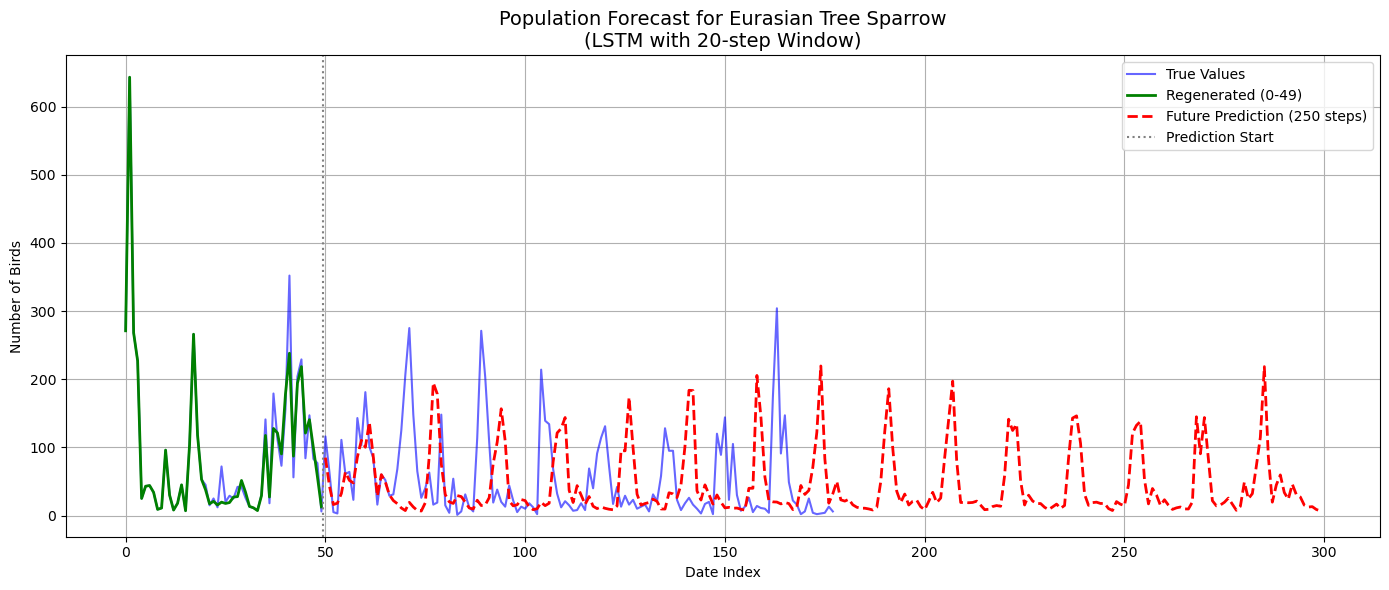

Model Performance Metrics of LSTM with 20-step Window:
MSE: 789.0247
RMSE: 28.0896
MAE: 16.7201


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

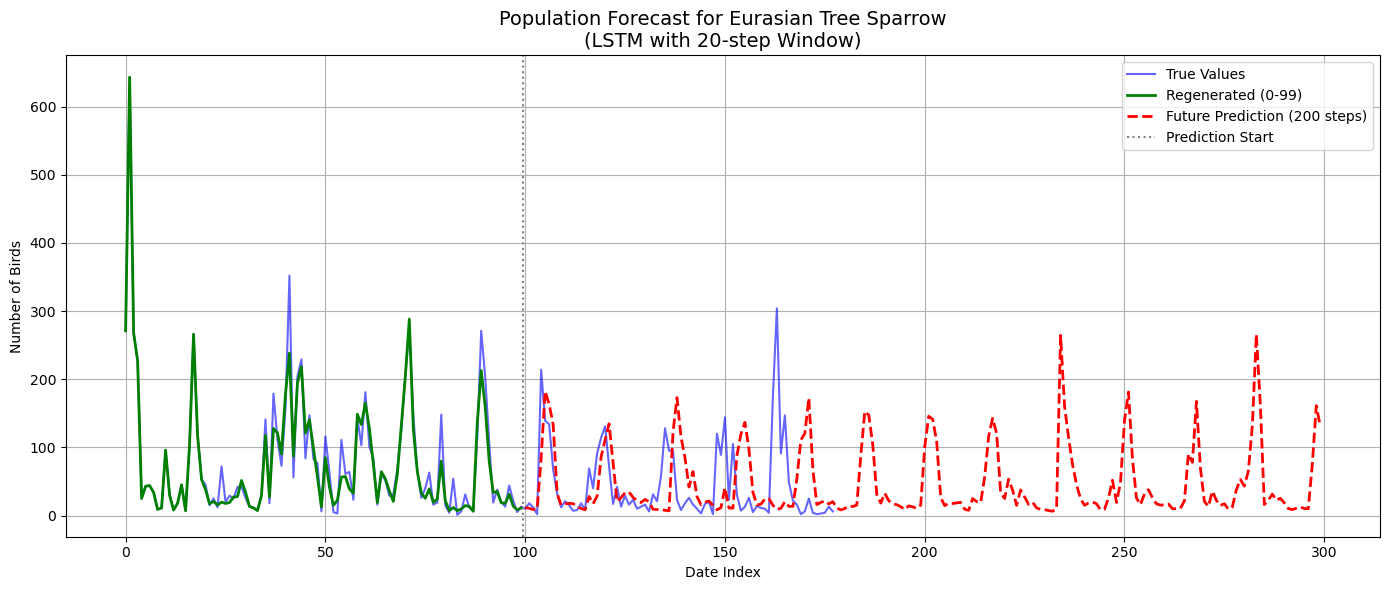

Model Performance Metrics of LSTM with 20-step Window:
MSE: 587.0981
RMSE: 24.2301
MAE: 15.5908


In [ ]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')
plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 


print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

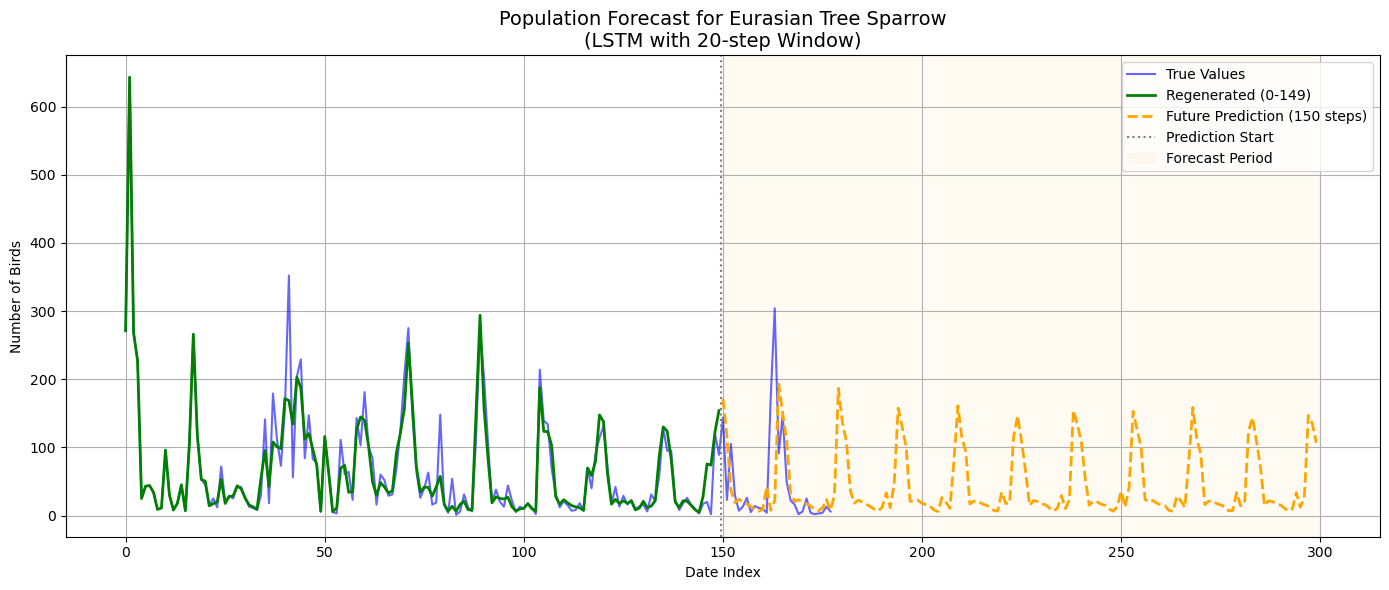

Model Performance Metrics of LSTM with 20-step Window:
MSE: 777.0239
RMSE: 27.8751
MAE: 15.8232
MAPE: 66.81%


In [25]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')
plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 


print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


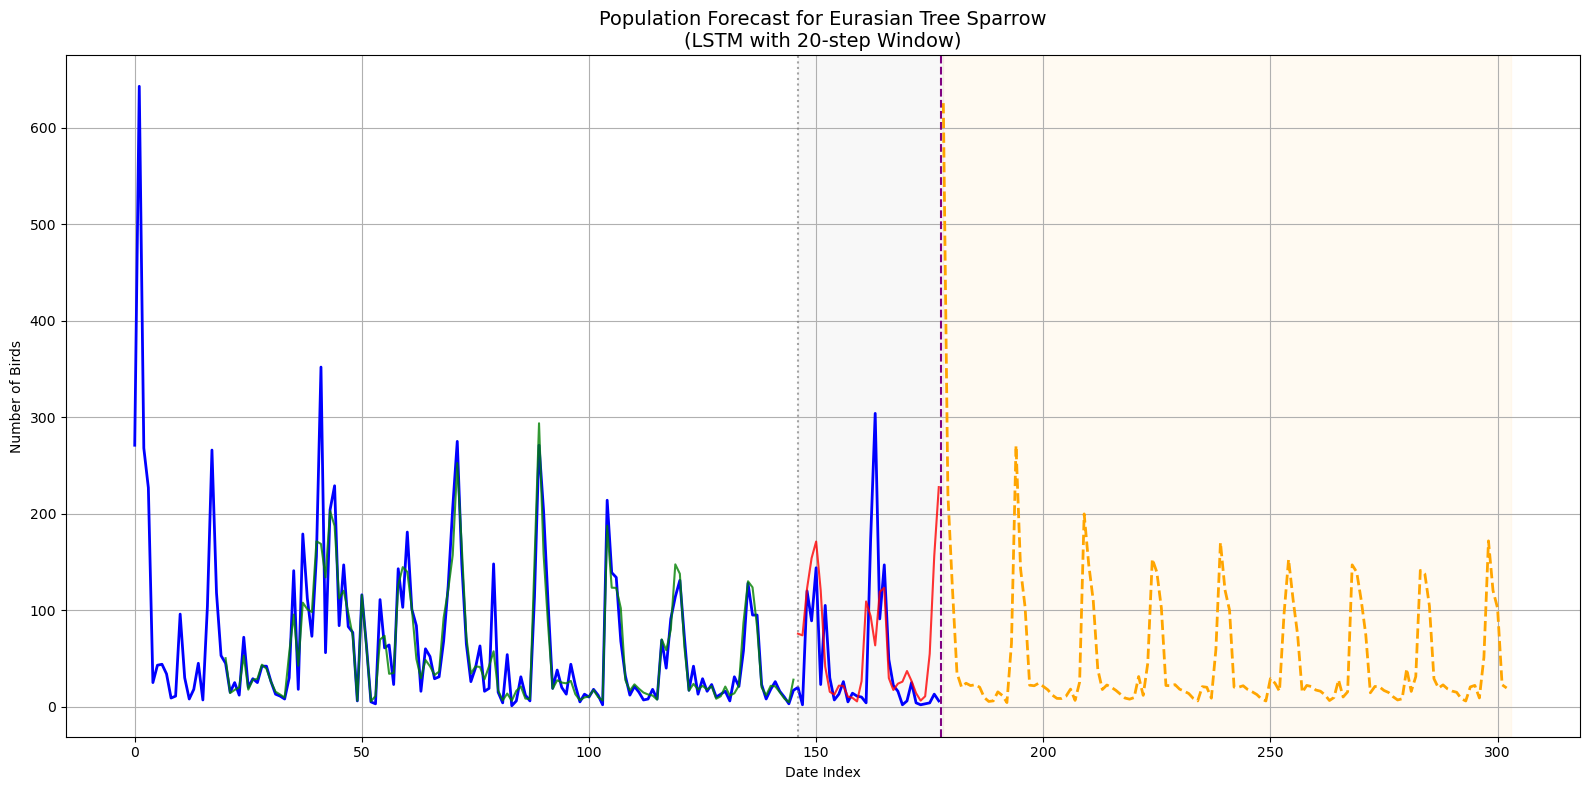


Model Performance Metrics of LSTM with 20-step Window:

Traning:

Training RMSE: 26.50
Training MSE: 702.42
Training MAE: 14.78
Training MAPE: 37.57%

Testing:

Test RMSE: 74.70
Test MSE: 5579.59
Test MAE: 45.41
Test MAPE: 514.04%


In [16]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------

train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [26]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 340.58
Step 2: 234.04
Step 3: 77.14
Step 4: 23.19
Step 5: 27.40
Step 6: 28.91
Step 7: 26.00
Step 8: 21.44
Step 9: 16.25
Step 10: 12.24
Step 11: 8.16
Step 12: 13.15
Step 13: 73.09
Step 14: 90.55
Step 15: 12.97
Step 16: 117.19
Step 17: 156.51
Step 18: 133.22
Step 19: 50.13
Step 20: 13.16
Step 21: 22.15
Step 22: 21.50
Step 23: 28.55
Step 24: 19.87
Step 25: 10.06
Step 26: 8.33
Step 27: 14.54
Step 28: 11.14
Step 29: 12.11
Step 30: 15.76
Step 31: 115.22
Step 32: 123.27
Step 33: 104.88
Step 34: 127.14
Step 35: 33.89
Step 36: 13.52
Step 37: 18.20
Step 38: 16.81
Step 39: 20.67
Step 40: 13.03
Step 41: 9.69
Step 42: 9.66
Step 43: 33.25
Step 44: 16.04
Step 45: 21.51
Step 46: 73.22
Step 47: 110.84
Step 48: 145.11
Step 49: 116.61
Step 50: 25.13
Step 51: 22.41
Step 52: 50.17
Step 53: 44.36
Step 54: 19.06
Step 55: 31.72
Step 56: 30.19
Step 57: 25.22
Step 58: 20.20
Step 59: 10.05
Step 60: 10.17
Step 61: 8.49
Step 62: 7.02
Step 63: 6.22
Step 64: 11.80
Step 65: 247

## **Window Size of 25**

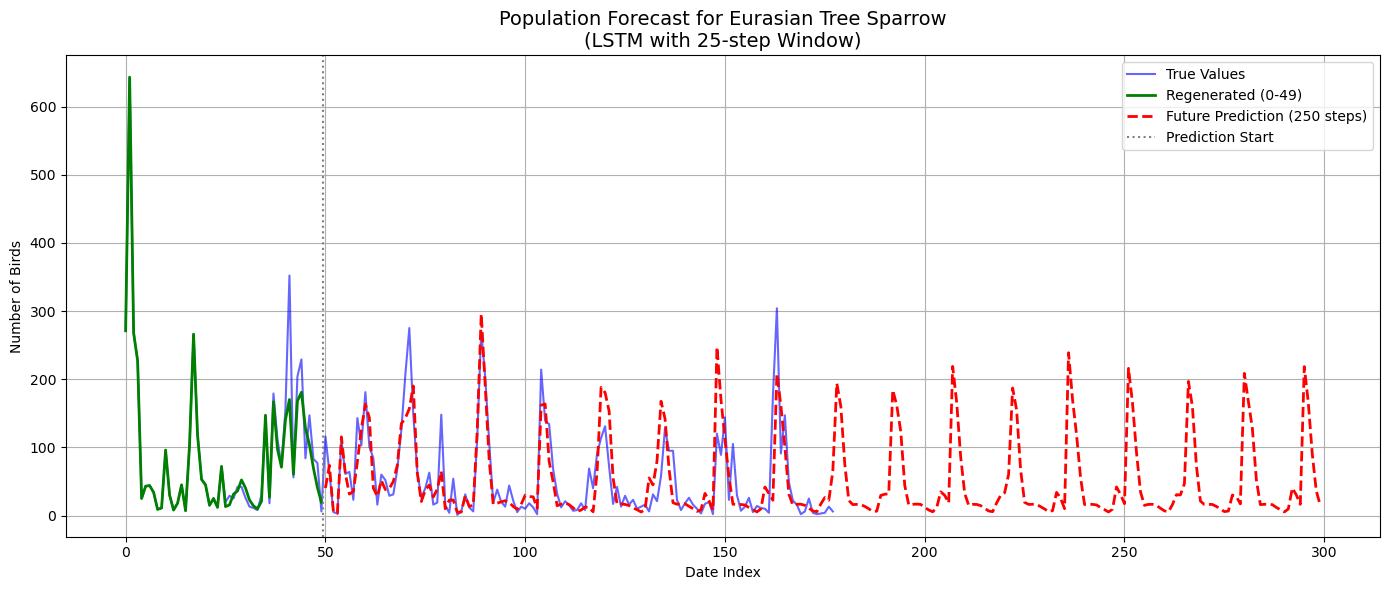

Model Performance Metrics of LSTM with 25-step Window:
MSE: 1746.2343
RMSE: 41.7880
MAE: 22.4310


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

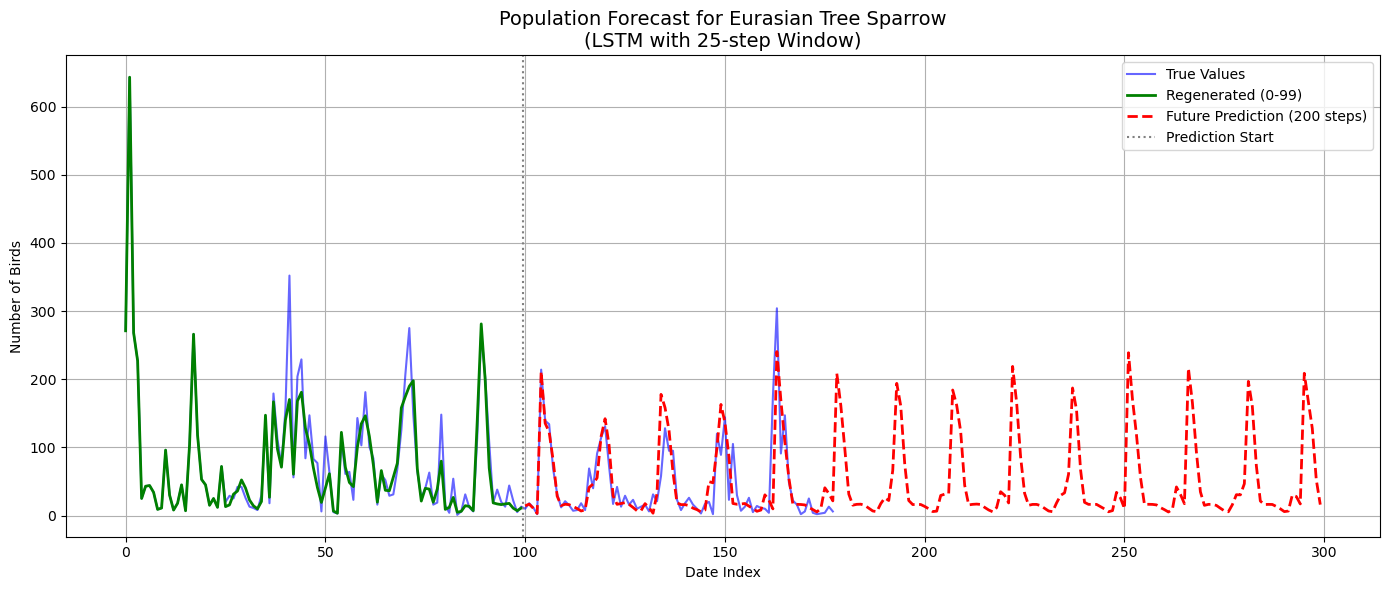

Model Performance Metrics of LSTM with 25-step Window:
MSE: 1036.7432
RMSE: 32.1985
MAE: 19.1176


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

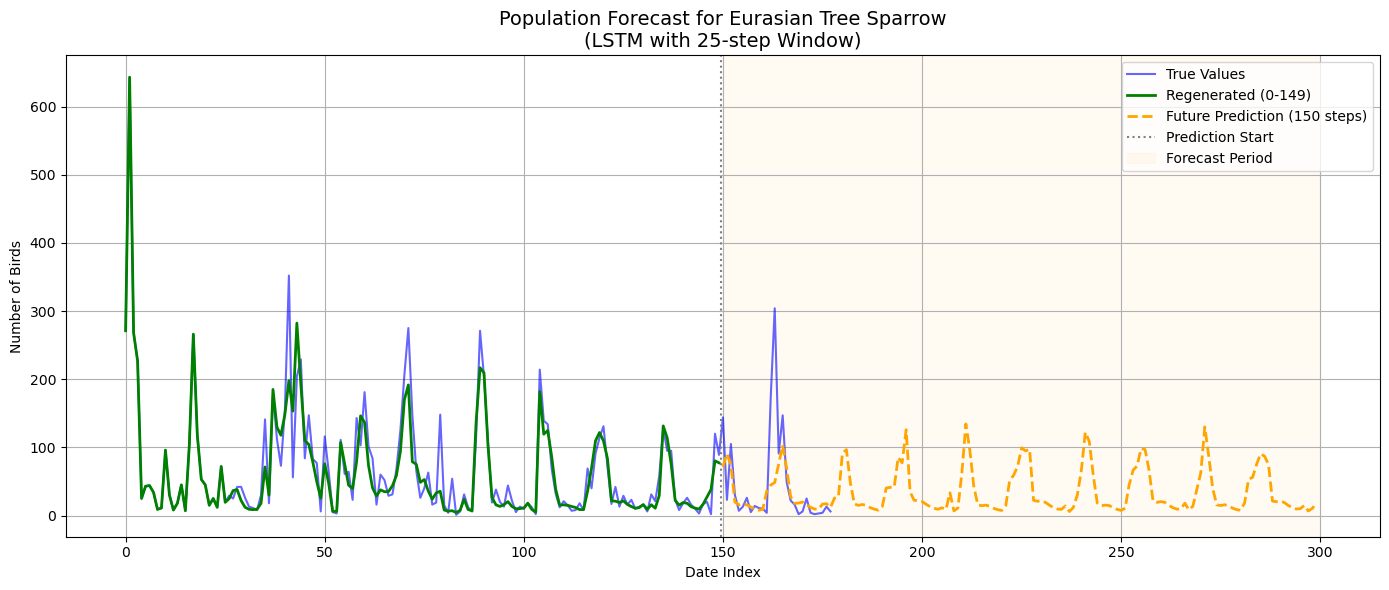

Model Performance Metrics of LSTM with 25-step Window:
MSE: 909.4066
RMSE: 30.1564
MAE: 18.5667
MAPE: 55.00%


In [39]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')
plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 


print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


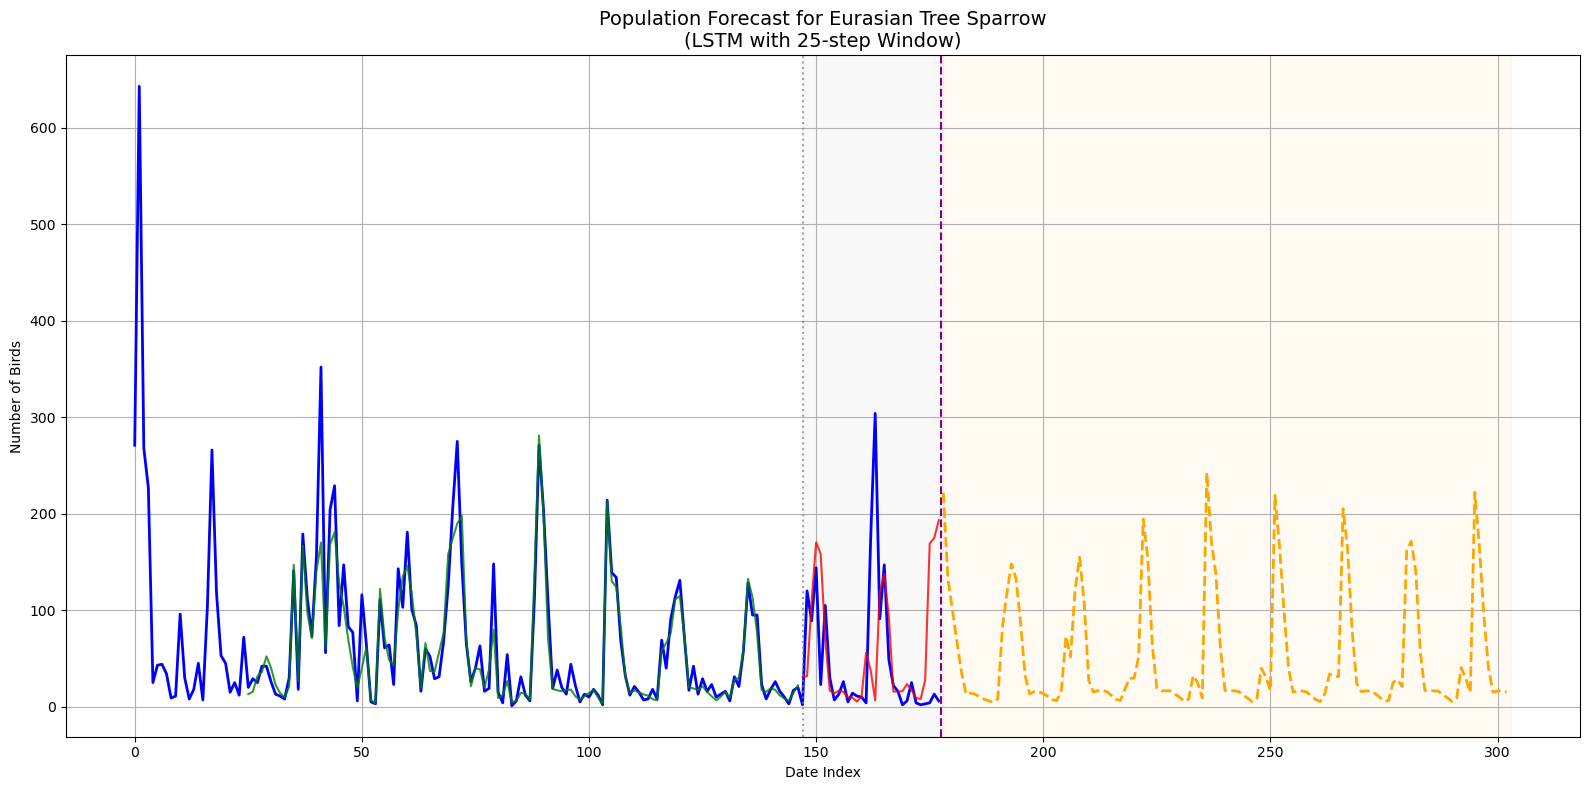


Model Performance Metrics of LSTM with {window_size}-step Window:
Training RMSE: 25.83
Test RMSE: 86.50
Training MAE: 14.16
Test MAE: 49.85


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------

train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [34]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 221.70
Step 2: 132.81
Step 3: 100.59
Step 4: 67.08
Step 5: 35.78
Step 6: 13.03
Step 7: 14.09
Step 8: 12.92
Step 9: 10.20
Step 10: 7.61
Step 11: 6.12
Step 12: 4.72
Step 13: 8.23
Step 14: 81.54
Step 15: 117.96
Step 16: 147.97
Step 17: 132.95
Step 18: 86.97
Step 19: 32.43
Step 20: 13.31
Step 21: 15.53
Step 22: 15.37
Step 23: 13.73
Step 24: 10.63
Step 25: 7.31
Step 26: 6.27
Step 27: 17.53
Step 28: 72.91
Step 29: 51.51
Step 30: 120.82
Step 31: 154.95
Step 32: 108.64
Step 33: 27.67
Step 34: 15.28
Step 35: 16.51
Step 36: 17.09
Step 37: 15.55
Step 38: 11.75
Step 39: 7.64
Step 40: 6.54
Step 41: 18.49
Step 42: 29.49
Step 43: 29.55
Step 44: 51.84
Step 45: 194.48
Step 46: 154.35
Step 47: 63.88
Step 48: 19.35
Step 49: 16.37
Step 50: 16.50
Step 51: 16.40
Step 52: 13.11
Step 53: 9.83
Step 54: 5.57
Step 55: 7.88
Step 56: 32.17
Step 57: 24.63
Step 58: 9.09
Step 59: 242.56
Step 60: 171.54
Step 61: 137.58
Step 62: 60.69
Step 63: 16.78
Step 64: 16.56
Step 65: 16.47


## **window size of 30**

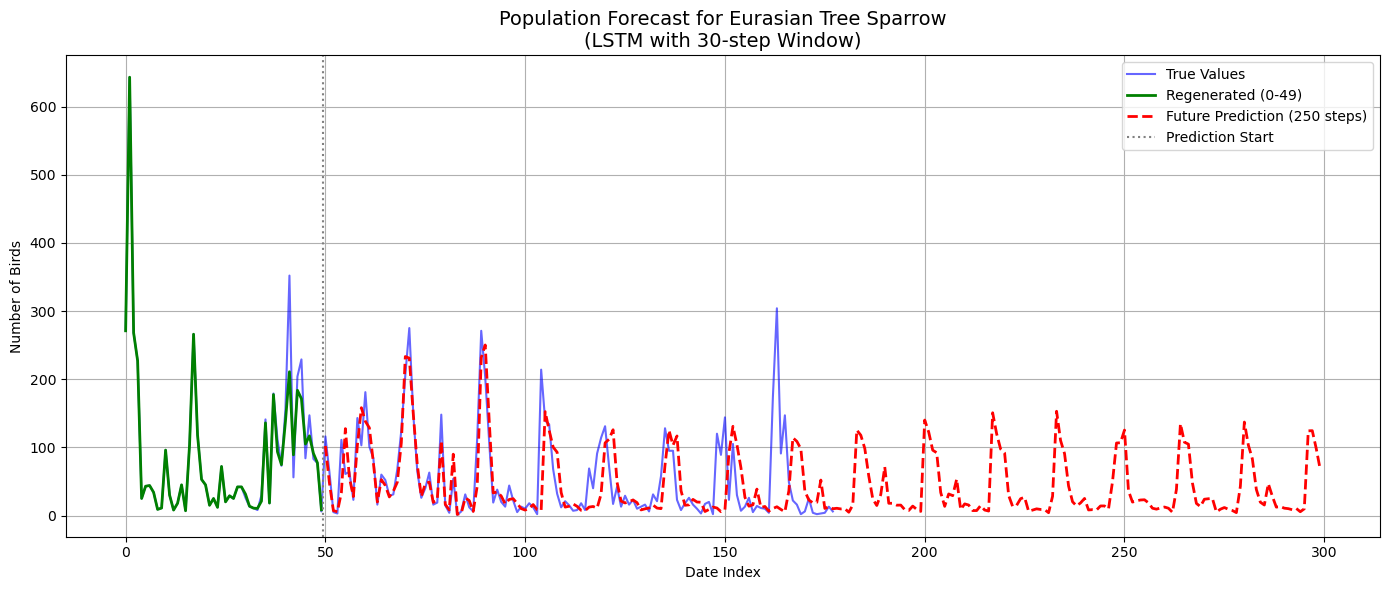

Model Performance Metrics of LSTM with 30-step Window:
MSE: 1347.2096
RMSE: 36.7044
MAE: 18.8063


In [ ]:
regenerate_points = 50  
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

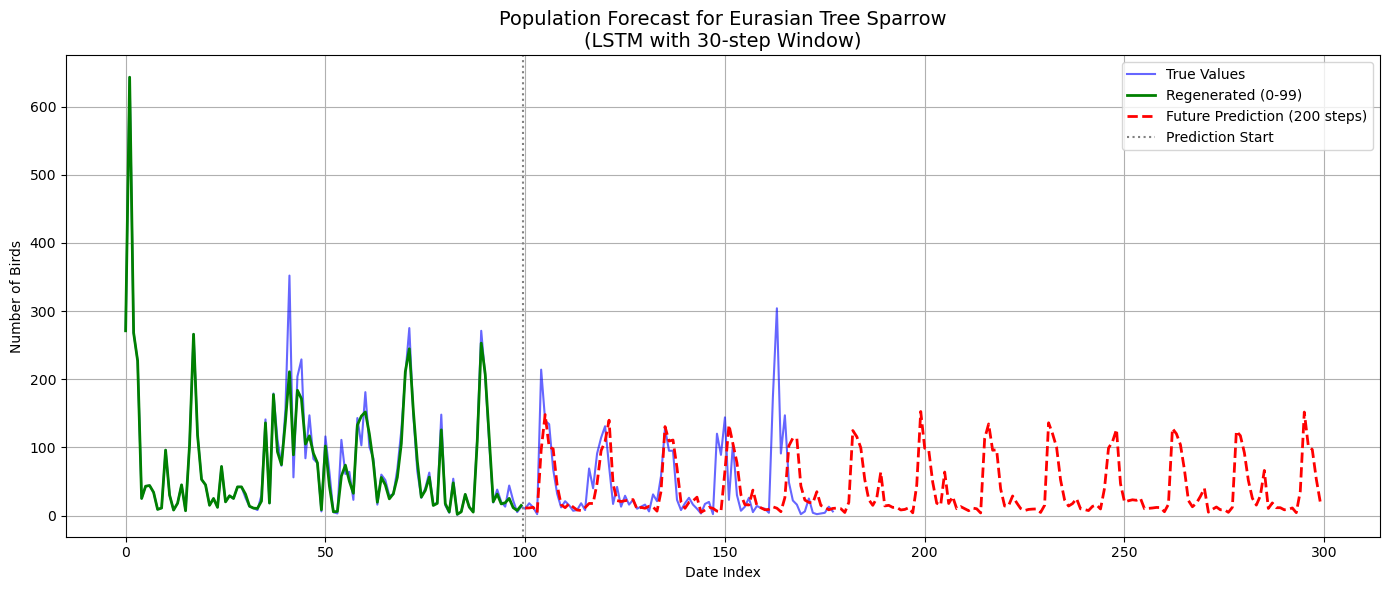

Model Performance Metrics of LSTM with 30-step Window:
MSE: 534.9111
RMSE: 23.1281
MAE: 12.1881


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

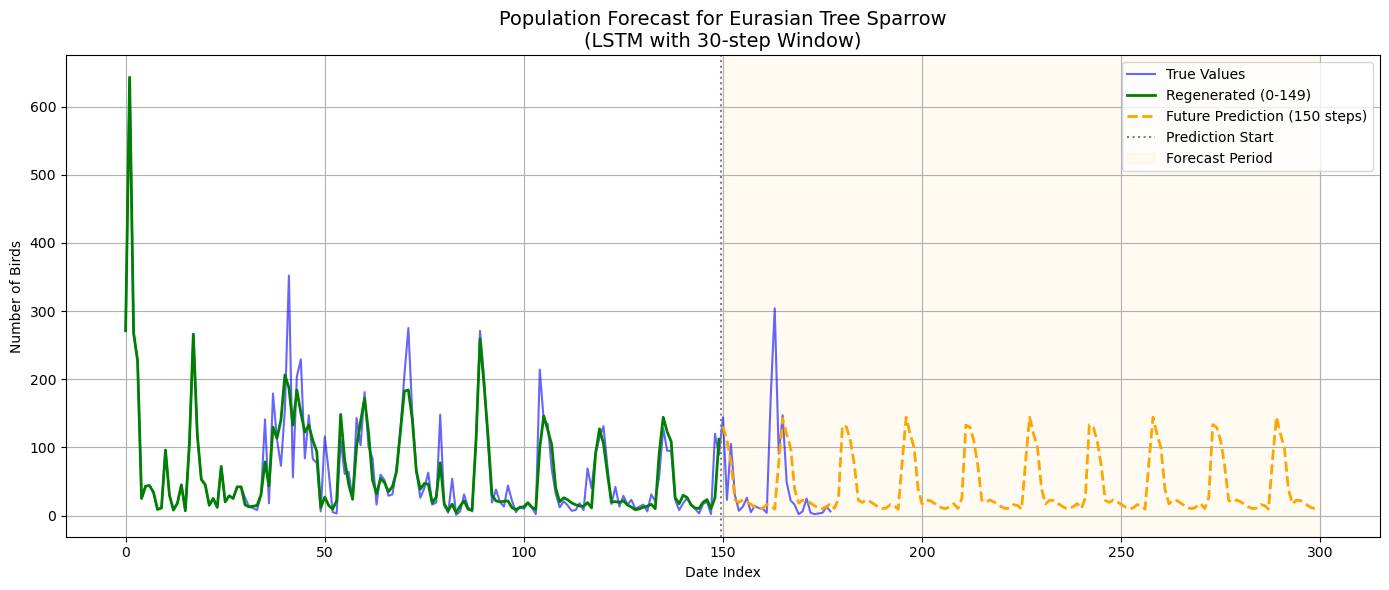

Model Performance Metrics of LSTM with 30-step Window:
MSE: 1032.9388
RMSE: 32.1394
MAE: 18.9283
MAPE: 52.58%


In [4]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')
plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 


print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


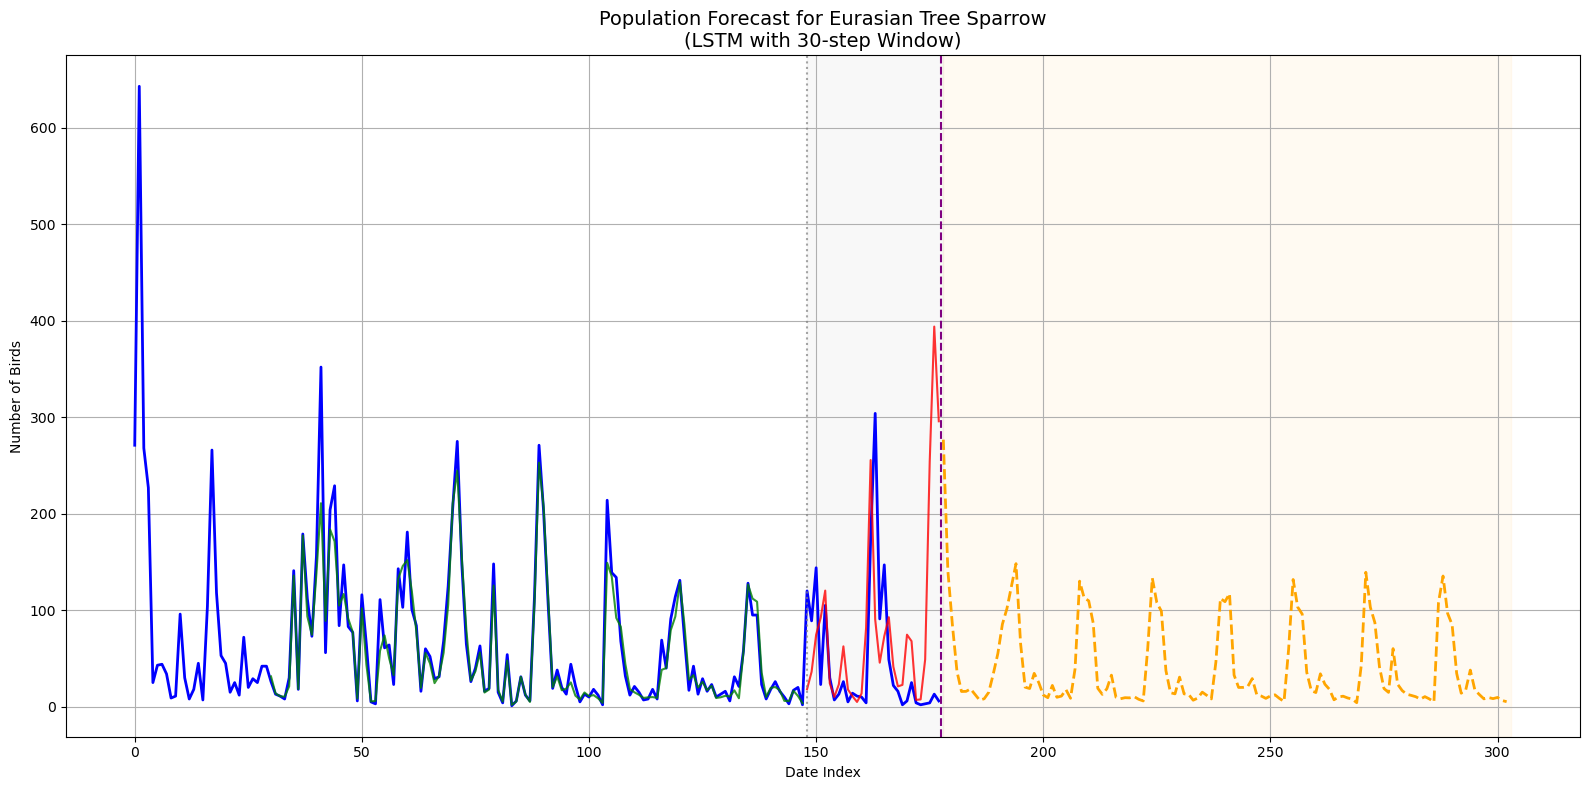


Model Performance Metrics of LSTM with {window_size}-step Window:
Training RMSE: 19.99
Test RMSE: 114.52
Training MAE: 10.64
Test MAE: 68.59


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [42]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 276.75
Step 2: 140.77
Step 3: 84.56
Step 4: 36.70
Step 5: 15.78
Step 6: 15.90
Step 7: 18.46
Step 8: 12.59
Step 9: 6.75
Step 10: 8.27
Step 11: 15.00
Step 12: 34.11
Step 13: 55.08
Step 14: 85.50
Step 15: 101.66
Step 16: 124.98
Step 17: 148.27
Step 18: 65.70
Step 19: 20.27
Step 20: 18.84
Step 21: 34.59
Step 22: 25.07
Step 23: 12.16
Step 24: 9.36
Step 25: 22.08
Step 26: 9.78
Step 27: 11.02
Step 28: 17.66
Step 29: 8.76
Step 30: 39.39
Step 31: 130.13
Step 32: 112.73
Step 33: 109.78
Step 34: 86.50
Step 35: 19.10
Step 36: 12.79
Step 37: 18.62
Step 38: 32.71
Step 39: 9.90
Step 40: 8.27
Step 41: 9.35
Step 42: 9.17
Step 43: 10.47
Step 44: 7.69
Step 45: 5.99
Step 46: 60.92
Step 47: 133.30
Step 48: 107.79
Step 49: 98.97
Step 50: 37.42
Step 51: 14.50
Step 52: 13.32
Step 53: 30.66
Step 54: 13.30
Step 55: 12.77
Step 56: 6.73
Step 57: 8.96
Step 58: 15.10
Step 59: 11.72
Step 60: 8.06
Step 61: 46.45
Step 62: 112.24
Step 63: 108.86
Step 64: 117.18
Step 65: 32.82
Ste

## **Window Size of 50**

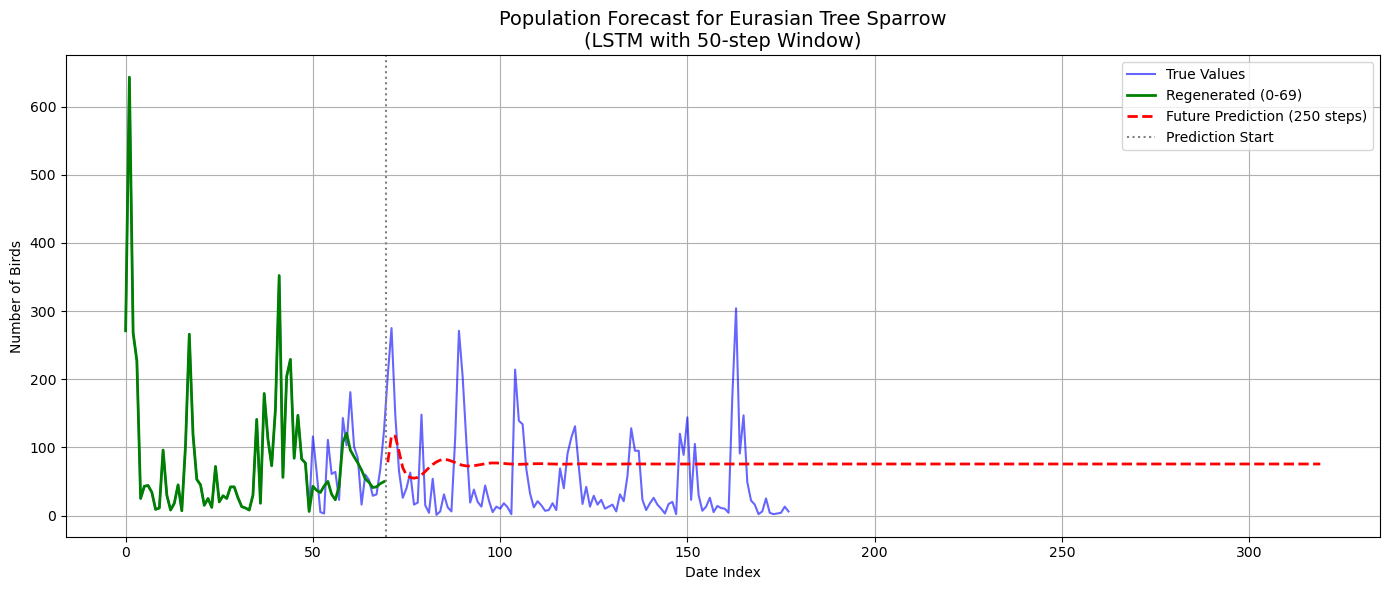

Model Performance Metrics of LSTM with 50-step Window:
MSE: 1663.2449
RMSE: 40.7829
MAE: 33.0275


In [ ]:
regenerate_points = 70
future_steps = 250


regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

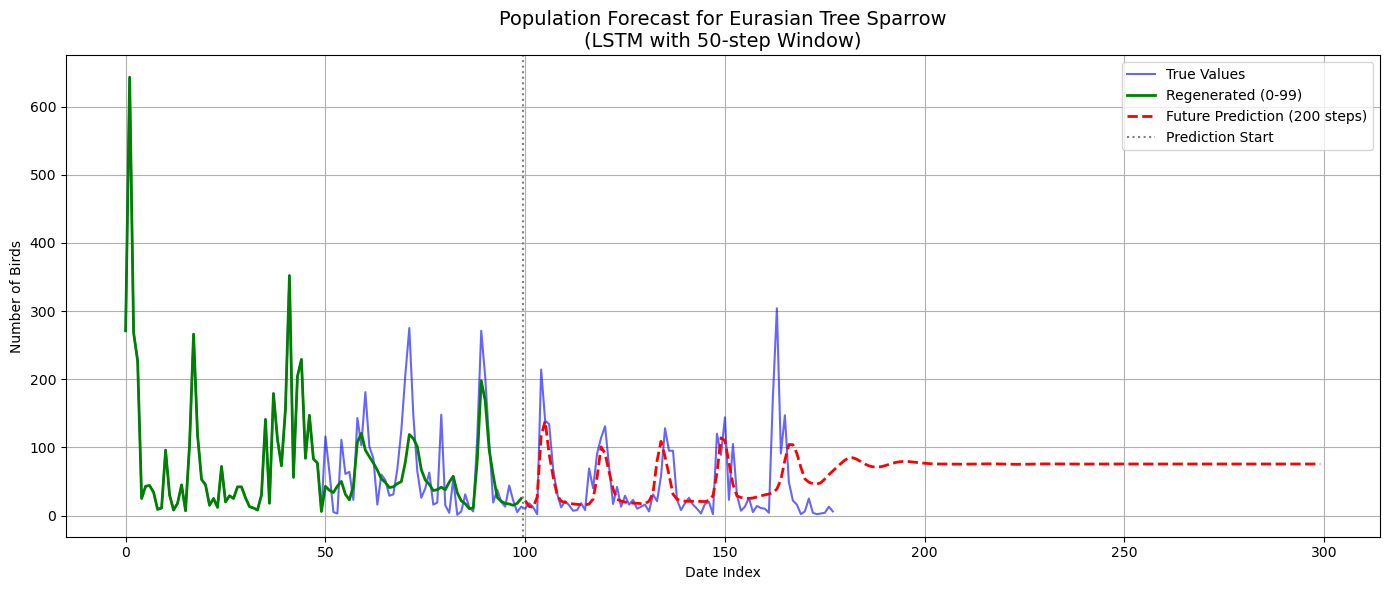

Model Performance Metrics of LSTM with 50-step Window:
MSE: 2111.4312
RMSE: 45.9503
MAE: 32.8332


In [ ]:
regenerate_points = 100
future_steps = 200

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='red', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')

plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)

print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

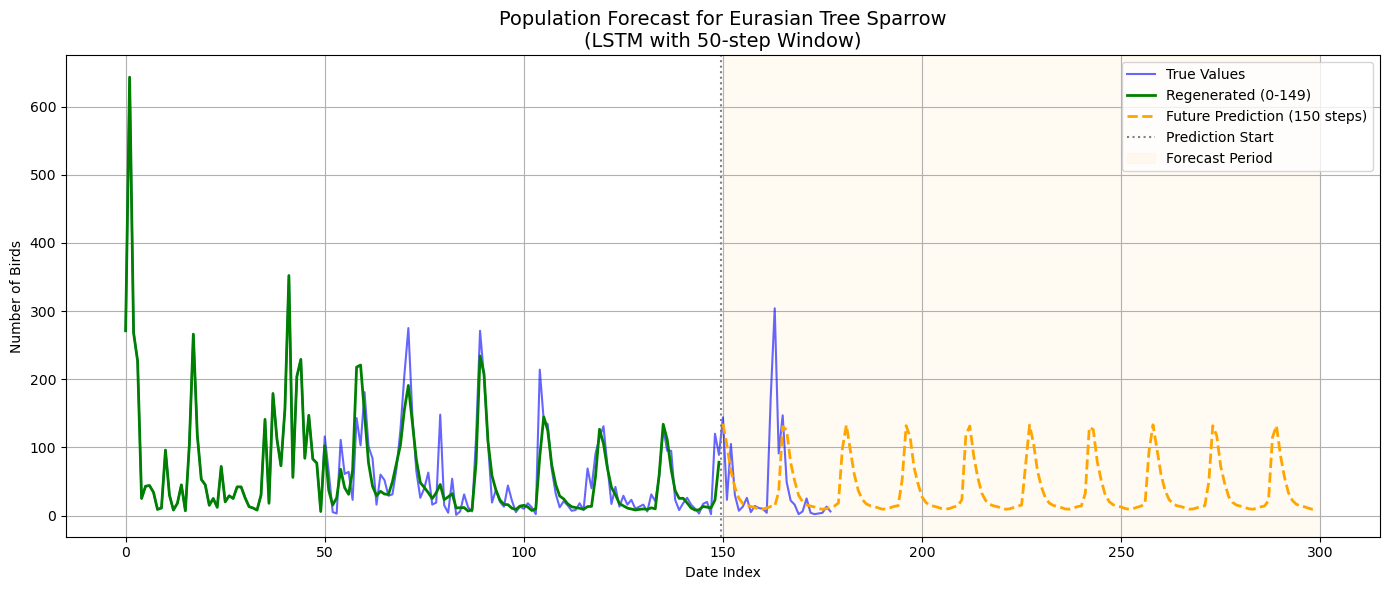

Model Performance Metrics of LSTM with 50-step Window:
MSE: 967.8951
RMSE: 31.1110
MAE: 19.6195
MAPE: 77.62%


In [47]:
regenerate_points = 150
future_steps = 150

regen_pred_actual = []


# -------------------------
# start from index 0
# -------------------------
for i in range(window_size):
    regen_pred_actual.append(values_scaled[i][0])  

# ------------------------------------------------
# predictions for points from window_size onwards
# ------------------------------------------------
for i in range(regenerate_points - window_size):
    input_window = values_scaled[i:i+window_size].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    regen_pred_actual.append(pred)

# Convert to numpy array and inverse transform
regen_pred_actual = np.expm1(np.array(regen_pred_actual).reshape(-1, 1))
regen_pred_actual[regen_pred_actual < 0] = 0

# -------------------------
# Future predictions 
# -------------------------
future_input = values_scaled[regenerate_points-window_size:regenerate_points]
future_predictions = []

for _ in range(future_steps):
    input_window = future_input[-window_size:].reshape(1, window_size, 1)
    pred = model.predict(input_window, verbose=0)[0,0]
    future_predictions.append(pred)
    future_input = np.append(future_input[1:], pred)  # Slide window

future_actual = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_actual[future_actual < 0] = 0

# -------------------------
# Ploting
# -------------------------
plt.figure(figsize=(14, 6))
plt.plot(values, label='True Values', color='blue', alpha=0.6)

plt.plot(range(0, regenerate_points), regen_pred_actual,
         label=f'Regenerated (0-{regenerate_points-1})',
         color='green', linewidth=2)

# Future predictions
future_start = regenerate_points
future_end = future_start + future_steps
plt.plot(range(future_start, future_end), future_actual,
         label=f'Future Prediction ({future_steps} steps)',
         color='orange', linestyle='--', linewidth=2)

# Transition line
plt.axvline(x=regenerate_points-0.5, color='gray', linestyle=':',
            label='Prediction Start')
plt.axvspan(future_start, future_end, color='orange', alpha=0.05, label='Forecast Period')


plt.title(f'Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)', fontsize=14)
plt.xlabel('Date Index')
plt.ylabel('Number of Birds')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

true_values_for_comparison = values[window_size:regenerate_points]
predicted_values = regen_pred_actual[window_size:]


# -------------------------
# metrics
# -------------------------
mse = mean_squared_error(true_values_for_comparison, predicted_values)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values_for_comparison, predicted_values)
mape = mean_absolute_percentage_error(true_values_for_comparison, predicted_values) * 100 


print(f"Model Performance Metrics of LSTM with {window_size}-step Window:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

**Regenerate training and testing, then predict future**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


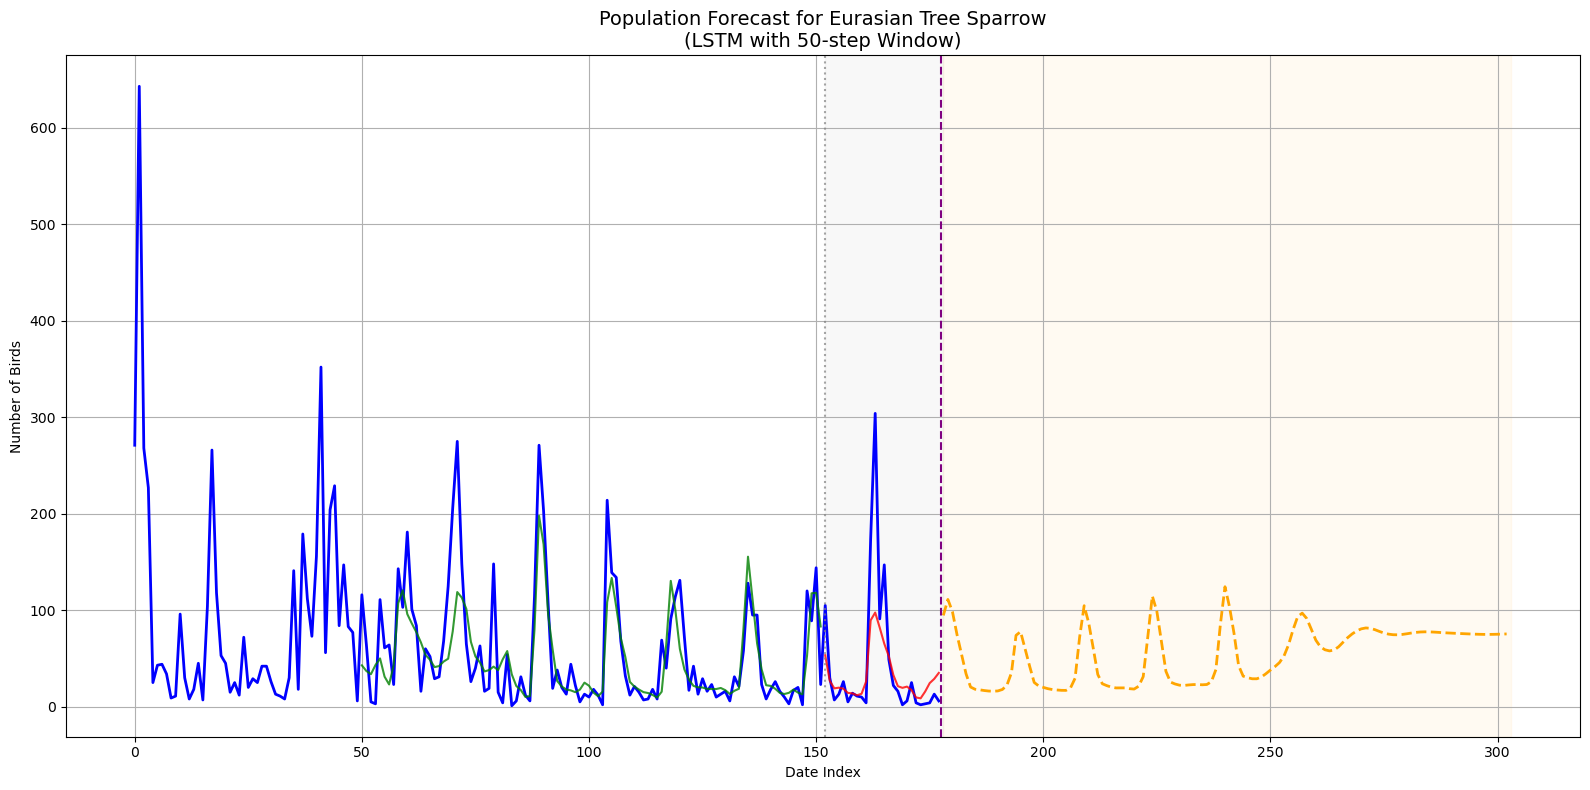


Model Performance Metrics of LSTM with {window_size}-step Window:
Training RMSE: 37.57
Test RMSE: 49.03
Training MAE: 25.06
Test MAE: 24.94


In [ ]:
# ---------------------
# Regenerate
# ---------------------
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred_inv = np.expm1(train_pred)
test_pred_inv = np.expm1(test_pred)
Y_train_inv = np.expm1(Y_train.reshape(-1, 1))
Y_test_inv = np.expm1(Y_test.reshape(-1, 1))


# ---------------------
# Future Forecasting
# ---------------------
future_steps = 125 
future_input = values_scaled[-window_size:]  # Use last window_size points
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(future_input.reshape(1, window_size, 1), verbose=0)
    future_predictions.append(pred[0, 0])
    
    # Shift window and append new prediction
    future_input = np.append(future_input[1:], [[pred[0, 0]]], axis=0)

# Inverse transform future predictions
future_predictions = np.expm1(np.array(future_predictions).reshape(-1, 1))
future_predictions[future_predictions < 0] = 0  # Ensure no negative values



# ---------------------
# Calculate positions for plotting
# ---------------------
train_start = window_size
train_end = train_start + len(train_pred_inv)

test_start = train_end
test_end = test_start + len(test_pred_inv)

future_start = len(values)  
future_end = future_start + future_steps



# ---------------------
# ploting
# ---------------------
plt.figure(figsize=(16, 8))

# Plot observed data
plt.plot(np.arange(len(values)), values, 
        label='Observed Data', color='blue', linewidth=2)

# Plot training predictions
plt.plot(np.arange(train_start, train_end), train_pred_inv, 
        label='Training Predictions', color='green', alpha=0.8)

# Plot test predictions
plt.plot(np.arange(test_start, test_end), test_pred_inv, 
        label='Test Predictions', color='red', alpha=0.8)

# Plot future forecast
plt.plot(np.arange(future_start, future_end), future_predictions, 
        label=f'{future_steps}-step Forecast', 
        color='orange', linestyle='--', linewidth=2)

# Vertical line and shaded regions
plt.axvline(x=test_start, linestyle=':', color='gray', alpha=0.7)
plt.axvline(x=len(values)-0.5, linestyle='--', color='purple', 
           label='Forecast Start')
plt.axvspan(test_start, len(values), color='gray', alpha=0.05, label='Test Period')
plt.axvspan(len(values), future_end, color='orange', alpha=0.05, label='Forecast Period')

plt.title(f"Population Forecast for {most_frequent_bird}\n(LSTM with {window_size}-step Window)", fontsize=14)
plt.xlabel("Date Index")
plt.ylabel("Number of Birds")
plt.grid()
plt.tight_layout()
plt.show()


# ---------------------
# metrics
# ---------------------
train_rmse = np.sqrt(mean_squared_error(Y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(Y_test_inv, test_pred_inv))

train_mse = mean_squared_error(Y_train_inv, train_pred_inv)
test_mse = mean_squared_error(Y_test_inv, test_pred_inv)

train_mape = mean_absolute_percentage_error(Y_train_inv, train_pred_inv)
test_mape = mean_absolute_percentage_error(Y_test_inv, test_pred_inv)

train_mae = mean_absolute_error(Y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(Y_test_inv, test_pred_inv)

print(f"\nModel Performance Metrics of LSTM with {window_size}-step Window:")

print(f"\nTraning:\n")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training MSE: {train_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Training MAPE: {train_mape*100:.2f}%")

print(f"\nTesting:\n")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MAPE: {test_mape*100:.2f}%")

In [50]:
print("Next 125 predicted bird counts:")
for i, count in enumerate(future_predictions.flatten(), 1):
    print(f"Step {i}: {count:.2f}")

Next 125 predicted bird counts:
Step 1: 94.63
Step 2: 111.15
Step 3: 98.62
Step 4: 74.95
Step 5: 54.46
Step 6: 34.06
Step 7: 20.39
Step 8: 18.07
Step 9: 17.51
Step 10: 16.78
Step 11: 16.24
Step 12: 16.08
Step 13: 16.36
Step 14: 17.87
Step 15: 22.34
Step 16: 35.22
Step 17: 73.95
Step 18: 77.76
Step 19: 59.93
Step 20: 41.95
Step 21: 25.17
Step 22: 21.48
Step 23: 20.05
Step 24: 18.70
Step 25: 17.79
Step 26: 17.34
Step 27: 16.98
Step 28: 16.92
Step 29: 19.54
Step 30: 29.48
Step 31: 72.00
Step 32: 104.70
Step 33: 86.85
Step 34: 60.58
Step 35: 33.44
Step 36: 23.79
Step 37: 21.81
Step 38: 20.27
Step 39: 19.47
Step 40: 19.51
Step 41: 19.51
Step 42: 18.68
Step 43: 18.28
Step 44: 21.27
Step 45: 31.20
Step 46: 72.07
Step 47: 114.77
Step 48: 98.92
Step 49: 67.80
Step 50: 36.65
Step 51: 25.54
Step 52: 23.56
Step 53: 22.30
Step 54: 22.06
Step 55: 22.56
Step 56: 22.94
Step 57: 23.01
Step 58: 22.74
Step 59: 23.01
Step 60: 25.88
Step 61: 38.48
Step 62: 85.83
Step 63: 124.35
Step 64: 103.37
Step 65: 75.

In [51]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 50, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,037 (343.90 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 58,692 (229.27 KB)